# 熱伝達

$q_c = \alpha_c \cdot (\theta_s - \theta_f)$

* $q_c$ ... 対流による伝熱量 [$W/m^2$]
* $\alpha_c$ ... 熱伝達率 [$W/m^2\cdot K$]
* $\theta_s$ ... 個体壁表面温 [${}^\circ\mathrm{C}$]
* $\theta_f$ ... 壁体から十分離れた流体(空気)の温度 [${}^\circ\mathrm{C}$]

(最新建築環境工学 P.35, P.185)

In [1]:
#matplotlib inline

import matplotlib.pyplot as plt
import math


In [2]:
#計算単位時間 dt[s]

dt = 1

In [3]:
class HeatCapacityObject:
    def __init__(self, V, cro, T = 0):
        self.V = V      #容積[m^3]
        self.cro = cro  #[kJ/m^3・K]
        self.T = T    #初期温度
        self.C = cro * 1000 * V  #熱容量[J/K]
        self.dU = 0   #熱の流量[J]
    
    def addHeat(self, U):
        dT = U / self.C
        self.T = self.T + dT

    def commit(self):
        dT = self.dU / self.C
        self.T = self.T + dT
        self.dU = 0

class Wall(HeatCapacityObject):
    def __init__(self, S, depth, cro = 854, T = 0):
        self.S = S
        self.depth = depth
        V = S * depth
        HeatCapacityObject.__init__(self, V, cro, T)

class Room(HeatCapacityObject):
    def __init__(self, V, T = 0):
        #空気熱容量の計算
        ro_air = 1.024  # [kg/m^3]  （920hPa,37℃,相対湿度50％RH）
        c_air = 1.007   # [kJ/kg・K] （920hPa,37℃）
        cro = ro_air * c_air  #[kJ/m^3・K]

        HeatCapacityObject.__init__(self, V, cro, T)

class ConvectiveHeatTransfer:
    def __init__(self, wall, room, c = 1.98):
        #c値
        #-----
        #暖房時の天井面または冷房時の床表面=2.67
        #暖房時の床表面または冷房時の天井面=0.64～0.87
        #垂直壁表面=1.98
        self.c = c
        
        self.wall = wall
        self.room = room
    
    def get_alpha_c(self, dT):
        return self.c * pow(dT, 0.25) 
    
    def get_U(self):
        dT = self.wall.T - self.room.T
        alpha_c = self.get_alpha_c(dT)
        q = alpha_c * dT
        U = q * wall.S
        return U
    
    def run(self, tick):
        U = self.get_U() * tick
        self.wall.addHeat(-U)
        self.room.addHeat(U)
    

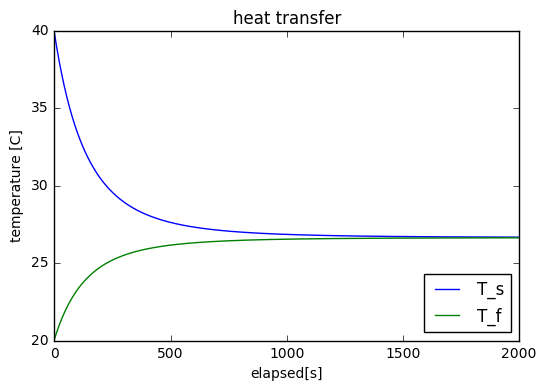

In [4]:
#壁(厚みは無視する)
cro_s = 854 # [kJ/m^3・K] せっこうボード
depth = 0.001  #厚み 0.001m
S = 6 #面積 6m^2
wall = Wall(S, depth, cro_s, 40)

#空気で見たされた部屋
room = Room(10, 20)

#自然換気対流
nv = ConvectiveHeatTransfer(wall, room)

#計算単位時間 dt[s]
dt = 1

data = []
for i in range(2000):
    #非定常計算
    for kernel in [nv]:
        kernel.run(dt)

    #定常計算
    for heatblock in [wall, room]:
        heatblock.commit()
    
    data.append((i*dt, wall.T, room.T))

#表示
x = [x[0] for x in data]
plt.title("heat transfer")
plt.plot(x, [y[1] for y in data], label="T_s")
plt.plot(x, [y[2] for y in data], label="T_f")
#plt.ylim(0,50)
plt.xlabel("elapsed[s]")
plt.ylabel("temperature [C]")
plt.legend(loc="lower right")
plt.show()